In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy

import functions as fx

from matplotlib import rc
from matplotlib import rcParams

from matplotlib.ticker import MultipleLocator, FormatStrFormatter

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

pad = 12
rcParams['xtick.major.pad'] = pad
rcParams['ytick.major.pad'] = pad

dpi = 200

%matplotlib inline

In [3]:
from astropy import units as u
from astropy.coordinates import SkyCoord

from galpy.orbit import Orbit
from galpy import potential

from galpy.util import bovy_conversion

In [6]:
ts = np.linspace(0,10,10000)*u.Gyr

## parameters for Hercules

gaiasys = 0.035

ra = 247.76639099999994
dec = 12.794125466666669
dist = 141.
dist_err = 3. 
# distance measurements from brown+2014
# i feel like if we're going to argue that tidal debris detections might be wrong,
# then we shouldn't use results from garling+

vlos = 45.5

pmra = -0.06
pmra_e = 0.11
pmdec = -0.44
pmdec_e = 0.09

# Fiducial model of Herc orbit

In [7]:
#parameterizing MW halo using params from McMillan 2017

c = 1.0
ro = 8.2
vo = 232.8

tp_amp= potential.TriaxialNFWPotential(amp=1.,a=2.,c=c)
mvir= tp_amp.mass(245./ro,245./ro,ro=ro,vo=vo)/10.**12. 
print(mvir)
# mass out to ~245 kpc in units of 10^12 Msun, for non-spherical potential need to give R and z max to integrate

tp= potential.TriaxialNFWPotential(amp=1.3/mvir,a=2.,c=c)
# amp = (0.8 x 10^12 Msun: desired mass) / (mvir x 10^12: mass for amp=1)
print(tp.mass(245./ro,245./ro,ro=ro,vo=vo)/10.**12.) # Should be the mass you want

bp= potential.PowerSphericalPotentialwCutoff(alpha=1.8,rc=1.9/ro,normalize=0.05) 
mp= potential.MiyamotoNagaiPotential(a=3./ro,b=0.28/ro,normalize=.6)

#seems like it's okay to replace the .8 factor with ro

pot_fid = [tp, bp, mp]

0.2001449702847074
1.3000000001287741


In [8]:
ts_small = np.linspace(0,5,5000)*u.Gyr

fid = Orbit([ra*u.degree,
            dec*u.degree,
            dist*u.kpc,
            pmra*u.mas/u.yr,
            pmdec*u.mas/u.yr,
            vlos*u.km/u.s],
            radec=True,solarmotion='Schoenrich',ro=ro*u.kpc,vo=vo*u.km/u.s)

fid_flip = fid.flip() 
fid_flip.integrate(ts_small,pot_fid)
fid_flip.flip(inplace=True)
fid.integrate(ts_small,pot_fid)

In [10]:
minix = np.argmin(fid_flip.r(ts_small)) 
print('In fiducial model from McMillan 2017, Herc made pericentric passage ' + 
      ("%.2f" % ts_small[minix].value) + ' Gyr ago, approaching ' + ("%.2f" % fid_flip.r(ts_small)[minix]) + 
      ' kpc of the Milky Way Center.')

In fiducial model from McMillan 2017, Herc made pericentric passage 0.51 Gyr ago, approaching 81.91 kpc of the Milky Way Center.


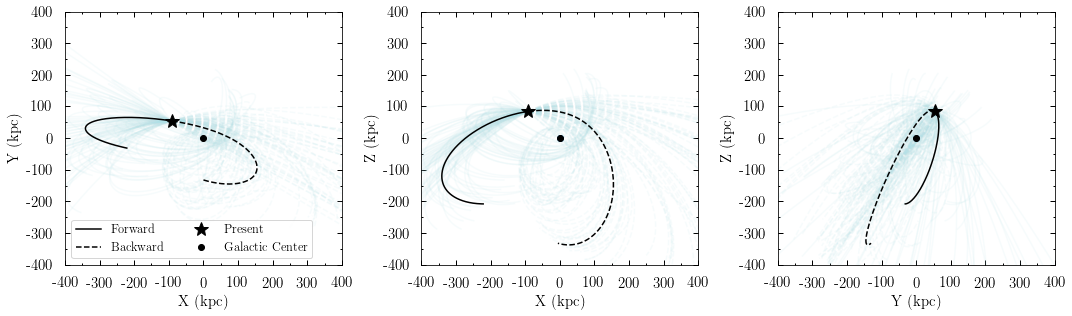

In [9]:
fig, ax = plt.subplots(1,3,figsize=(15,4.5))

ax[0].plot(fid.x(ts_small),fid.y(ts_small),color='black',ls='-',label='Forward', zorder=1000)
ax[0].plot(fid_flip.x(ts_small),fid_flip.y(ts_small),color='black',ls='--',label='Backward', zorder=1000)
ax[0].plot(fid_flip.x(ts_small)[0],fid_flip.y(ts_small)[0],color='black',ls='None',zorder=1000,
          marker='*',markersize=15, label='Present')
ax[0].set_xlabel('X (kpc)',fontsize=15)
ax[0].set_ylabel('Y (kpc)',fontsize=15)

ax[1].plot(fid.x(ts_small),fid.z(ts_small),color='black',ls='-',zorder=1000)
ax[1].plot(fid_flip.x(ts_small),fid_flip.z(ts_small),color='black',ls='--',zorder=1000)
ax[1].plot(fid_flip.x(ts_small)[0],fid_flip.z(ts_small)[0],color='black',ls='None',zorder=1000,
          marker='*',markersize=15)
ax[1].set_xlabel('X (kpc)',fontsize=15)
ax[1].set_ylabel('Z (kpc)',fontsize=15)
ax[1].plot(0,0,marker='o',ls='None')


ax[2].plot(fid.y(ts_small),fid.z(ts_small),color='black',ls='-',zorder=1000)
ax[2].plot(fid_flip.y(ts_small),fid_flip.z(ts_small),color='black',ls='--',zorder=1000)
ax[2].plot(fid_flip.y(ts_small)[0],fid_flip.z(ts_small)[0],color='black',ls='None',zorder=1000,
          marker='*',markersize=15, label='Present')
ax[2].set_xlabel('Y (kpc)',fontsize=15)
ax[2].set_ylabel('Z (kpc)',fontsize=15)
ax[2].plot(0,0,marker='o',ls='None')

major_tick_length = 5
major_tick_width = 1
minor_tick_length = 2
minor_tick_width = 1

np.random.seed(4747)

plot_sampsize = 100

pmra_plot = np.random.normal(pmra, np.sqrt(np.square(pmra_e) + np.square(gaiasys)),plot_sampsize)
pmde_plot = np.random.normal(pmdec, np.sqrt(np.square(pmdec_e) + np.square(gaiasys)), plot_sampsize)

for k in range(plot_sampsize):
    orb = Orbit([ra*u.degree,
            dec*u.degree,
            dist*u.kpc,
            pmra_plot[k]*u.mas/u.yr,
            pmde_plot[k]*u.mas/u.yr,
            vlos*u.km/u.s],
            radec=True,solarmotion='Schoenrich',ro=ro*u.kpc,vo=vo*u.km/u.s)

    orb_flip = orb.flip() 
    orb_flip.integrate(ts_small,pot_fid)
    orb_flip.flip(inplace=True)
    orb.integrate(ts_small,pot_fid)
    
    ax[0].plot(orb_flip.x(ts_small), orb_flip.y(ts_small),ls='--',color='powderblue',alpha=0.1)
    ax[1].plot(orb_flip.x(ts_small), orb_flip.z(ts_small),ls='--',color='powderblue',alpha=0.1)
    ax[2].plot(orb_flip.y(ts_small), orb_flip.z(ts_small),ls='--',color='powderblue',alpha=0.1)

    ax[0].plot(orb.x(ts_small), orb.y(ts_small),ls='-',color='powderblue',alpha=0.1)
    ax[1].plot(orb.x(ts_small), orb.z(ts_small),ls='-',color='powderblue',alpha=0.1)
    ax[2].plot(orb.y(ts_small), orb.z(ts_small),ls='-',color='powderblue',alpha=0.1)


for i in range(3):
    ax[i].set_xlim(-400,400)
    ax[i].set_ylim(-400,400)
    ax[i].plot(0,0,marker='o',ls='None',label='Galactic Center',color='black')
    
    ax[i].xaxis.set_major_locator(MultipleLocator(100))
    ax[i].xaxis.set_minor_locator(MultipleLocator(50))

    ax[i].yaxis.set_major_locator(MultipleLocator(100))
    ax[i].yaxis.set_minor_locator(MultipleLocator(50))

    ax[i].set_xticklabels(np.round(np.arange(-500,500,100),0),fontsize=15)
    ax[i].set_yticklabels(np.round(np.arange(-500,500,100),0),fontsize=15)

    ax[i].tick_params(axis='both',direction='in',bottom='on',top='on',right='on',left='on',which='major',
                 length = major_tick_length, width = major_tick_width)
    ax[i].tick_params(axis='both',direction='in',bottom='on',top='on',right='on',left='on',which='minor',
                  length = minor_tick_length, width = minor_tick_width)

ax[0].legend(fontsize=12.5,loc='lower left',ncol=2)

fig.tight_layout()

fig.savefig('Herc_fiducial_M17.pdf',dpi=dpi,
            bbox_inches='tight')

# Reading in the results of the MC


In [12]:
# these are the arrays used to generate the samples of the MCMC
# when plotting results of mc, PLOT THIS

np.random.seed(4747)

sampsize=5000

dist_ar = np.random.normal(dist, dist_err, sampsize)
pmra_ar = np.random.normal(pmra, np.sqrt(np.square(pmra_e) + np.square(gaiasys)),sampsize)
pmde_ar = np.random.normal(pmdec, np.sqrt(np.square(pmdec_e) + np.square(gaiasys)), sampsize)

mass_ar = np.random.normal(1.3, 0.3, sampsize) 
# i totally screwed up the thing from before but anyway THIS IS FOR MCMILLAN PARAMETERIZATION
# FOR AMP, THE FACTOR IS JUST WHATEVER MULTIPLE OF 10^12 THAT YOU WANT YOUR POTENTIAL TO BE
c_grid = np.array([0.5,0.6,0.7,0.8,0.9,1.0]) 

# Testing orbit of Hercules in range of MW masses and flattening

In [14]:
np.random.seed(4747)

sampsize = 5000

dist_ar = np.random.normal(dist, dist_err, sampsize)
pmra_ar = np.random.normal(pmra, np.sqrt(np.square(pmra_e) + np.square(gaiasys)),sampsize)
pmde_ar = np.random.normal(pmdec, np.sqrt(np.square(pmdec_e) + np.square(gaiasys)), sampsize)

mass_ar = np.random.normal(1.3, 0.3, sampsize) 
# i totally screwed up the thing from before but anyway THIS IS FOR MCMILLAN PARAMETERIZATION
# FOR AMP, THE FACTOR IS JUST WHATEVER MULTIPLE OF 10^12 THAT YOU WANT YOUR POTENTIAL TO BE
# I THINK THE MASS IS OK NOW
c_grid = np.array([0.5,0.6,0.7,0.8,0.9,1.0]) 

In [15]:
#parameterizing MW halo using params from McMillan 2017

c = 1.
ro = 8.2
vo = 232.8

tp_amp= potential.TriaxialNFWPotential(amp=1.,a=2.,c=c)
mvir= tp_amp.mass(245./ro,245./ro,ro=ro,vo=vo)/10.**12. 
print(mvir)
# mass out to ~245 kpc in units of 10^12 Msun, for non-spherical potential need to give R and z max to integrate

tp= potential.TriaxialNFWPotential(amp=1.3/mvir,a=2.,c=c) 
# amp = (0.8 x 10^12 Msun: desired mass) / (mvir x 10^12: mass for amp=1)
print(tp.mass(245./ro,245./ro,ro=ro,vo=vo)/10.**12.) # Should be the mass you want

bp= potential.PowerSphericalPotentialwCutoff(alpha=1.8,rc=1.9/ro,normalize=0.05) 
mp= potential.MiyamotoNagaiPotential(a=3./ro,b=0.28/ro,normalize=.6)

#seems like it's okay to replace the .8 factor with ro

0.2001449702847074
1.3000000001287741


In [ ]:
ts = np.linspace(0,10,10000)*u.Gyr

peri_total = np.array([])
c_total = np.array([])
tr_total = np.array([]) #i'm only doing this for flat halo
eccen_total = np.array([]) #i'm only doing this for flat halo 

for k in range(c_grid.size):
#     print(k)
    c = c_grid[k]
    c_arr = np.empty(sampsize)
    c_arr.fill(c)
    
    c_total = np.concatenate([c_total,c_arr])
    
    peri = np.empty(sampsize)
    tr = np.empty(sampsize)
    eccen = np.empty(sampsize)
    
    for i in range(sampsize):
        tp= potential.TriaxialNFWPotential(amp=mass_ar[i]/mvir,a=2.,c=c) 
        
        if i % 100 == 0:
            print(k, i)

        pot = [tp,bp,mp]

        orb = Orbit([ra*u.degree,
                     dec*u.degree,
                     dist_ar[i]*u.kpc,
                     pmra_ar[i]*u.mas/u.yr,
                     pmde_ar[i]*u.mas/u.yr,
                     vlos*u.km/u.s],
                    radec=True,solarmotion='Schoenrich',ro=ro*u.kpc,vo=vo*u.km/u.s)

        orb_flip = orb.flip() 
        orb_flip.integrate(ts,pot)

        peri[i] = orb_flip.rperi()
        
        if c > 0.95:
            tr[i] = orb_flip.Tr()
            eccen[i] = orb_flip.e()
        
    if c < 0.95:
        peri_total = np.concatenate([peri_total,peri])
        tr = np.empty(sampsize)
        tr.fill(np.nan)
        eccen = np.empty(sampsize)
        eccen.fill(np.nan)
        
        eccen_total = np.concatenate([eccen_total, eccen])
        tr_total = np.concatenate([tr_total, tr])
    else:
        peri_total = np.concatenate([peri_total,peri])
        tr_total = np.concatenate([tr_total,tr])
        eccen_total = np.concatenate([eccen_total, eccen])
    